In [1]:
import tensorflow as tf
import numpy
import math
import matplotlib.pyplot as plt
import pickle
import os
from tqdm import tqdm
from IPython.display import clear_output

%matplotlib inline

In [2]:
sess = tf.Session()

In [3]:
k_const = 1.0
m_const = 1.0
omega_sq_const = k_const / m_const

x0_const = 0.0
speed0_const = 1.0


In [5]:
hidden_layer_units = 8
amount_of_points = 15
min_time = 0
max_time = 2 * math.pi 

In [6]:
min_element = -1
max_element = 1

In [7]:
alpha = tf.constant(0.007, dtype=tf.double)

In [8]:
w1_matrix = numpy.random.uniform(min_element, max_element, (hidden_layer_units, 1))
offset1_matrix = numpy.random.uniform(min_element, max_element, (hidden_layer_units, 1))
w2_matrix = numpy.random.uniform(min_element, max_element, (1, hidden_layer_units))


In [9]:
t_list = numpy.linspace(min_time, max_time, amount_of_points).reshape((1, amount_of_points))
x_expected = numpy.sin(omega * t_list)

In [10]:
t_cv = numpy.linspace(min_time, max_time, 1000).reshape((1, 1000))


In [11]:
def numpy_sigmoid(x):
    res = 1 / (1 + numpy.exp(-x))
    return res

In [25]:
speed

<tf.Tensor 'gradients/MatMul_grad/MatMul_1:0' shape=(1, ?) dtype=float64>

In [12]:
w1 = tf.Variable(w1_matrix, dtype=tf.double, name='w1')
offset1 = tf.Variable(offset1_matrix, dtype=tf.double, name='offset1')
w2 = tf.Variable(w2_matrix, dtype=tf.double, name='w2')
# -----------------------------------------------------------
t = tf.placeholder(tf.double)
# -----------------------------------------------------------
k = tf.constant(k_const, dtype=tf.double, name='k')
m = tf.constant(m_const, dtype=tf.double, name='m')
omega_sq = k / m
# -----------------------------------------------------------
x0 = tf.constant(x0_const, dtype=tf.double, name='x0')
speed0 = tf.constant(speed0_const, dtype=tf.double, name='speed0')
begin_hamiltonian = (k * (x0 ** 2) / 2) + (m * (speed0 ** 2) / 2)
# -----------------------------------------------------------
init = tf.global_variables_initializer()
sess.run(init)


In [13]:
# forward prop  
hidden_layer = tf.sigmoid(tf.matmul(w1, t) + offset1)
x = tf.matmul(w2, hidden_layer)
# calculate speed and acc
speed = tf.gradients(x, t)[0]
acc = tf.gradients(speed, t)[0]
# calculate cost
equation_part = tf.reduce_sum((acc + omega_sq * x) ** 2)
begin_part = ((x[0][0] - x0) ** 2) + ((speed[0][0] - speed0) ** 2)
current_hamiltonian = (k * (x ** 2) / 2) + (m * (speed ** 2) / 2)
hamilton_part = tf.reduce_sum((current_hamiltonian - begin_hamiltonian) ** 2)
cost = (1 / amount_of_points) * (equation_part + begin_part + hamilton_part)
# calculate_grads
grad = tf.gradients(cost, [w1, offset1, w2])
# gradient descent
w1_ass = w1.assign_sub(alpha * grad[0])
offset1_ass = offset1.assign_sub(alpha * grad[1])
w2_ass = w2.assign_sub(alpha * grad[2])

In [22]:
x

<tf.Tensor 'MatMul_1:0' shape=(1, ?) dtype=float64>

In [14]:
# gradient descent run
sess.run(init)
J_list = []
for i in tqdm(range(300000)):
    _, _, _, cur_cost = sess.run([w1_ass, offset1_ass, w2_ass, cost], {t: t_list})
    if (i%10000) == 0:
        clear_output()
        print(cur_cost)
    if (cur_cost<1e-6):
        break
    J_list.append(cur_cost ** (-1))

 97%|█████████▋| 290137/300000 [05:08<00:10, 915.87it/s]

0.000161313553887


100%|██████████| 300000/300000 [05:18<00:00, 941.63it/s] 


6581.67434762


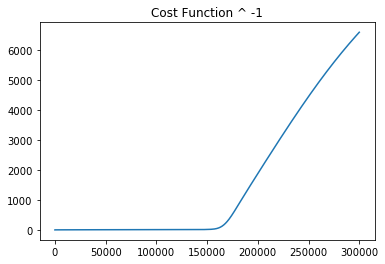

In [15]:
plt.title('Cost Function ^ -1')
plt.plot(J_list)
print(J_list[-1])

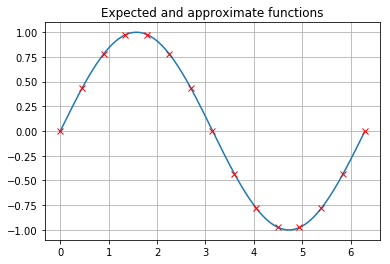

In [16]:
x_cv = sess.run(x, {t: t_cv})
plt.title('Expected and approximate functions')
plt.grid(True)
plt.plot(t_cv[0], x_cv[0])
plt.plot(t_list[0],x_expected[0], 'x', color='red')

In [17]:
w1_matrix = sess.run(w1)
offset1_matrix = sess.run(offset1)
w2_matrix = sess.run(w2)

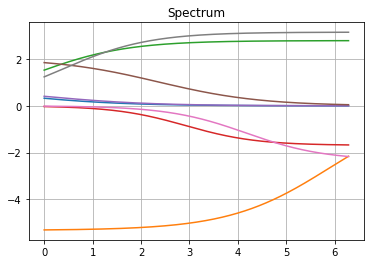

In [18]:
plt.grid(True)
plt.title("Spectrum")
for i in range(hidden_layer_units):
    cur_sigm = w2_matrix[0][i] * numpy_sigmoid((w1_matrix[i][0] * t_cv) + offset1_matrix[i][0])
    plt.plot(t_cv[0], cur_sigm[0])

In [19]:
#save_params('cos(x)')